In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('final.csv') 


In [3]:
X = data.drop(['MB'], axis=1)  
y = data['MB']  

In [4]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% for training, 30% for testing + validation
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)  # Split 30% into 10% validation and 20% test

In [5]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [6]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

In [7]:
def f1_score(y_true, y_pred):
    y_pred = tf.round(tf.nn.sigmoid(y_pred))  
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, 'float'))
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, 'float'))
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), 'float'))

    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return f1

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Logistic regression layer
])

In [9]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=[
                  'accuracy',
                  tf.keras.metrics.AUC(name='auc'),
                  f1_score
                      ]
             )


In [10]:
history = model.fit(
    X_train_smote, 
    y_train_smote, 
    epochs=10, 
    batch_size=32, 
    validation_data=(X_val, y_val), 
    verbose=1,
    class_weight=class_weight_dict
)


Epoch 1/10
712/712 [==============================] - 1s 450us/step - loss: 0.6994 - accuracy: 0.5177 - auc: 0.8159 - f1_score: 0.6624 - val_loss: 0.9843 - val_accuracy: 0.1855 - val_auc: 0.9827 - val_f1_score: 0.3046
Epoch 2/10
712/712 [==============================] - 0s 349us/step - loss: 0.4433 - accuracy: 0.5946 - auc: 0.9886 - f1_score: 0.6617 - val_loss: 0.7727 - val_accuracy: 0.5408 - val_auc: 0.9871 - val_f1_score: 0.3046
Epoch 3/10
712/712 [==============================] - 0s 325us/step - loss: 0.3478 - accuracy: 0.7824 - auc: 0.9893 - f1_score: 0.6617 - val_loss: 0.6005 - val_accuracy: 0.6937 - val_auc: 0.9871 - val_f1_score: 0.3046
Epoch 4/10
712/712 [==============================] - 0s 323us/step - loss: 0.2827 - accuracy: 0.8412 - auc: 0.9891 - f1_score: 0.6623 - val_loss: 0.4975 - val_accuracy: 0.7604 - val_auc: 0.9871 - val_f1_score: 0.3046
Epoch 5/10
712/712 [==============================] - 0s 384us/step - loss: 0.2408 - accuracy: 0.8721 - auc: 0.9890 - f1_score: 

In [11]:
# Get predictions for training
y_train_pred = model.predict(X_train)
y_train_pred_class = tf.round(y_train_pred)  # Convert probabilities to class predictions

# Generate confusion matrix for training
cm_train = confusion_matrix(y_train, y_train_pred_class)
tn_train, fp_train, fn_train, tp_train = cm_train.ravel()
sensitivity_train = tp_train / (tp_train + fn_train)
specificity_train = tn_train / (tn_train + fp_train)

print(f"Training Sensitivity: {sensitivity_train:.2f}")
print(f"Training Specificity: {specificity_train:.2f}")

# Get predictions for validation
y_val_pred = model.predict(X_val)
y_val_pred_class = tf.round(y_val_pred)  # Convert probabilities to class predictions

# Generate confusion matrix for validation
cm_val = confusion_matrix(y_val, y_val_pred_class)
tn_val, fp_val, fn_val, tp_val = cm_val.ravel()
sensitivity_val = tp_val / (tp_val + fn_val)
specificity_val = tn_val / (tn_val + fp_val)

print(f"Validation Sensitivity: {sensitivity_val:.2f}")
print(f"Validation Specificity: {specificity_val:.2f}")


430/430 [==============================] - 0s 181us/step
Training Sensitivity: 1.00
Training Specificity: 0.83
62/62 [==============================] - 0s 205us/step
Validation Sensitivity: 1.00
Validation Specificity: 0.83


In [12]:
history = model.evaluate(
    X_test, 
    y_test, 
)


123/123 [==============================] - 0s 277us/step - loss: 0.3001 - accuracy: 0.8632 - auc: 0.9904 - f1_score: 0.3110


In [13]:
# Get predictions for test data
y_test_pred = model.predict(X_test)
y_test_pred_class = tf.round(y_test_pred)  # Convert probabilities to class predictions

# Generate confusion matrix for test
cm_test = confusion_matrix(y_test, y_test_pred_class)
tn_test, fp_test, fn_test, tp_test = cm_test.ravel()
sensitivity_test = tp_test / (tp_test + fn_test)
specificity_test = tn_test / (tn_test + fp_test)

print(f"Test Sensitivity: {sensitivity_test:.2f}")
print(f"Test Specificity: {specificity_test:.2f}")


123/123 [==============================] - 0s 207us/step
Test Sensitivity: 1.00
Test Specificity: 0.83


In [15]:
import shap


In [32]:
background_data = shap.kmeans(X_train, 10)  # Use 10 clusters, adjust as necessary
explainer = shap.KernelExplainer(model.predict, background_data)
shap_values = explainer.shap_values(X_test)

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/3925 [00:00<?, ?it/s]

664/664 [==============================] - 0s 425us/step


In [42]:
shap_values_reshaped = np.squeeze(shap_values)  # Removes the last dimension
print(shap_values_reshaped.shape)

(3925, 38)


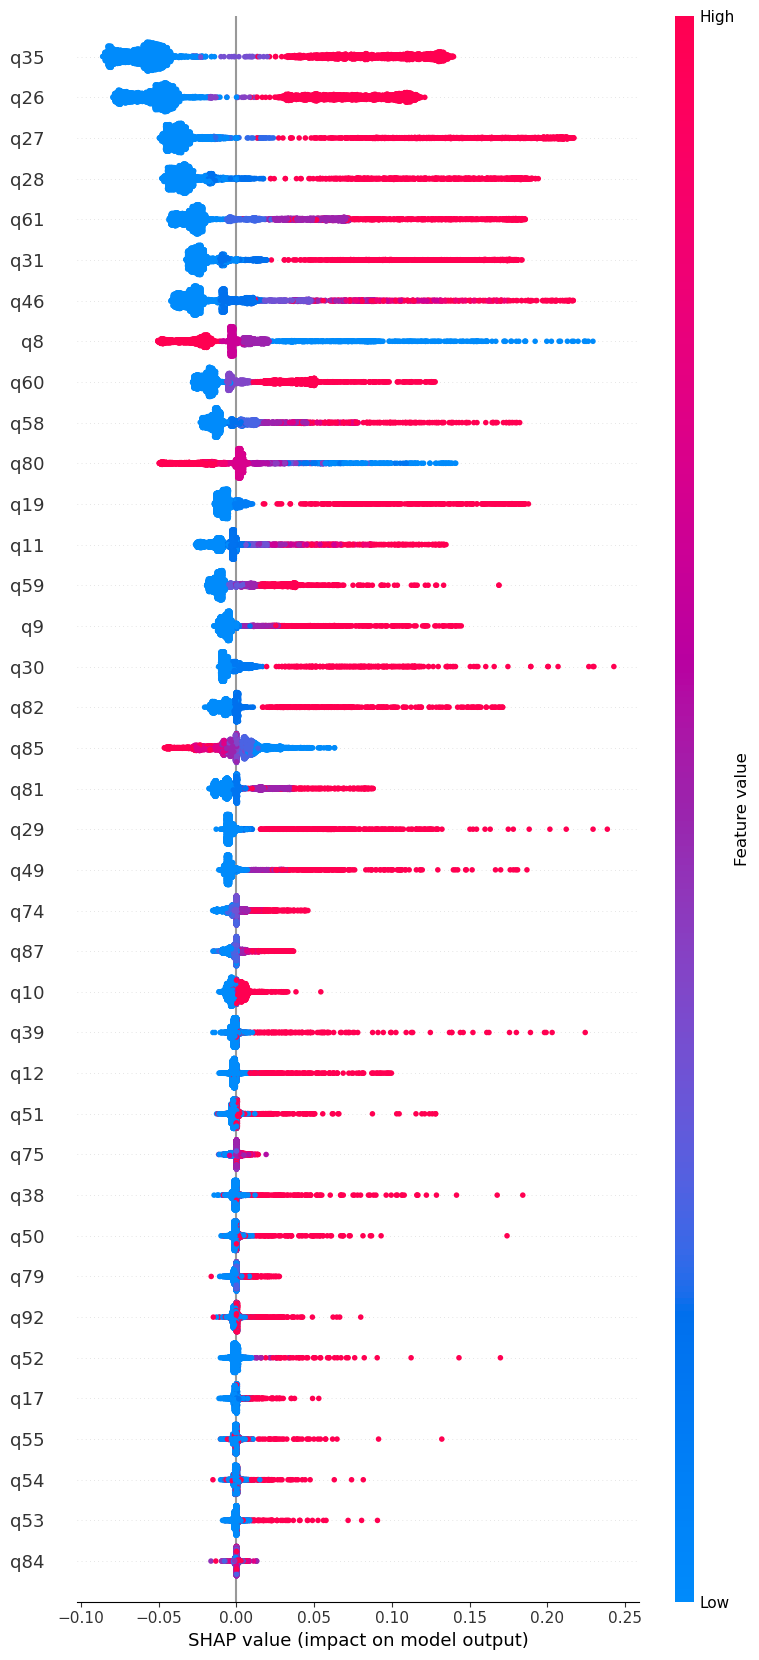

In [46]:
shap.summary_plot(shap_values_reshaped, X_test, max_display=X_test.shape[1])

In [54]:
for feature_idx, feature_name in enumerate(X_test.columns):
    # Get the index of the row with the highest SHAP value (absolute)
    max_idx = np.argmax(np.abs(shap_values[:, feature_idx]))
    
    # Print the feature name and its most impactful value
    print(f"Feature: {feature_name}, Most Impactful Value: {X_test.iloc[max_idx, feature_idx]}")

Feature: q8, Most Impactful Value: 0.0
Feature: q9, Most Impactful Value: 1.0
Feature: q10, Most Impactful Value: 1.0
Feature: q11, Most Impactful Value: 1.0
Feature: q12, Most Impactful Value: 1.0
Feature: q17, Most Impactful Value: 1.0
Feature: q19, Most Impactful Value: 1.0
Feature: q26, Most Impactful Value: 1.0
Feature: q27, Most Impactful Value: 1.0
Feature: q28, Most Impactful Value: 1.0
Feature: q29, Most Impactful Value: 1.0
Feature: q30, Most Impactful Value: 1.0
Feature: q31, Most Impactful Value: 1.0
Feature: q35, Most Impactful Value: 1.0
Feature: q38, Most Impactful Value: 1.0
Feature: q39, Most Impactful Value: 1.0
Feature: q46, Most Impactful Value: 1.0
Feature: q49, Most Impactful Value: 1.0
Feature: q50, Most Impactful Value: 1.0
Feature: q51, Most Impactful Value: 1.0
Feature: q52, Most Impactful Value: 1.0
Feature: q53, Most Impactful Value: 1.0
Feature: q54, Most Impactful Value: 0.8
Feature: q55, Most Impactful Value: 1.0
Feature: q58, Most Impactful Value: 1.0
Fe